# Projeto 1 - Ciência dos Dados

Nome: Letícia Coêlho Barbosa

Nome: Matheus Silva Melo de Oliveira

## Contextualização

------------------------------------------------------------

O produto escolhido para a classificação foi a tão falada e renomada série do Universo de Star Wars,<em><b>The Mandalorian</b></em> atualmente vinculado à Disney e transmitido no serviço de assinatura Disney+.

<br>

A classificação foi realizada com intuito de analisar caso internautas ou possíveis consumidores da série comentam sobre esta na rede social Twitter. O critério utilizado para relevância foi caso o usuário fizesse algum comentário que remetia algum laço de intensidade em relação à série, positivo ou não, como elogiando algum capítulo, sentindo saudade da série ou criticando algum aspecto relevante à obra. Tweets que falavam apenas de aspectos tangentes à esse certame, como elogios ou comentários a atores da obra, listagens no qual à série se enquadra e vagas menções sobre a série foram consideradas como irrelevantes nessa classificação.

<em>Alguns dos principais tópicos contidos nos tweets</em>
- Elogiando episódio final da segunda temporada
- Elogiando o personagem principal da obra, Mandaloriano ou o personagem em CGI, apeliadado de "Baby Yoda"
- Elogios à série, com advérbios que remetem falta da série, que está em hiato, ou elogios à história
- Comentários alheios a atores e atrizes da obra, como Pedro Pascal
- Comparações com outras obras, principalmente Wandavision, do mesmo serviço de streaming Disney+

<br>

<center><img src="mandalorian_assets/mandalorian.gif" width=500 style="float: center; margin: 0px 0px 10px 10px"></center>
<center><b>Cena da série do Disney+</b></center>

## Bibliotecas Utilizadas

------------------------------------------------------------

Caso não possuir bibliotecas utilizadas descomentar célula abaixo:

In [1]:
%matplotlib notebook
# !pip install seaborn
# !pip install emoji
# !pip install pysinonimos
# !pip install nltk
# !pip install sklearn

Carregando algumas bibliotecas essenciais:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

Carregando algumas bibliotecas para limpeza:

In [3]:
import re 
import emoji
import nltk
import pysinonimos.sinonimos as sinom
from emoji import UNICODE_EMOJI

Carregando demais bibliotecas de uso específico:

In [4]:
import seaborn as sn
from math import ceil
from sklearn.model_selection import train_test_split

Confirmando diretório de trabalho

In [5]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\Leticia\Documents\INSPER\2_Semestre\C_Dados\Projeto 1\TheMandalorian


## Banco de Dados

------------------------------------------------------------

Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [6]:
filename = 'mandalorian_assets/mandalorian.xlsx'

In [7]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Relevancia
0,executivo da disney defendeu demissão de gina ...,0
1,@daredvevil nao seriooo melhor dia 😭 volta the...,1
2,preciso terminar mandalorian logo,0
3,toda vez que eu vejo o baby yoda usando a forç...,0
4,jon fraveau eu te amo obrigado por fazer the m...,0


In [8]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head()

,Teste,Relevancia
0,the mandalorian é uma série com dinheiro e tec...,1
1,agora comecei mandalorian confiando novamente ...,1
2,@fepazo1 @gabriel_ns1999 @joelmsimmons @jurand...,1
3,eu assisti 3 minutos de mandalorian e emocionei,1
4,rt @anakinwar: já ta ...,0


## Classificador automático de sentimento

------------------------------------------------------------

Iremos nesse passo de definição das funções de limpeza seguir os seguintes passos:
* Limpar itens comuns e pontuações, como "@" e '!';
* Retirar espaços entre emojis e textos, assim como substituir os emojis por suas transcrições utilizando sua descrição em seu próprio UNICODE.
* Retirar preposições do texto, visto que essas raramente agregam algum sentimento de intensidade em relação ao produto e são meramente necessárias ao sentido da frase especificada;
* Tornar, caso tenha-se, palavras com letras maiúsculas em letras minúsculas para evitar diferenciações entre palavras iguais como "gosto" e "Gosto";
* Dividindo as palavras em listas para análise probalística de cada palavra de pertencer ao respectivo grupo (nota-se que aqui foram excluídos termos como 'rt' e 'https' que nao agregam na análise).
* Funções de divisão e concatenção de palavras;
* Função de aplicação, que junta os fragmentos de palavras separados com os emojis transcritos, aplicando simultaneamente todas as funções anteriores garantindo uma limpeza efetiva conforme os critérios avaliados justos pelo grupo.
* Função de retorno de série com as palavras que apareceram em cada tweet, importante para formação relativa de cada palavra na base de dados.


#### Definindo Funções


In [9]:
#Limpando os tweets retirando pontos desnecessarios
def limpeza(tweet):
    '''
    Limpando sinais, arrombas, aspas e outras pontuações.
    '''
    punctuation = '[”@\-/!.:?;,''"]'             
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern,'', tweet)
    return text_subbed

In [10]:
def separa_emoji(tweet):
    '''
    Essa função separa os emojis juntos, além de transcreve-los
    para suas respectivas strings descritivas, optimizando um pouco o processamento.
    Nota-se que alguns emojis não usados não estão no Unicode da língua portuguesa,
    adotamos assim o de língua inglesa como alternativa de transcrição.
    '''
    modified=' '.join(emoji.get_emoji_regexp().split(tweet))
    modified=modified.split()
    for i,emoji1 in enumerate(modified):
        if emoji1 in UNICODE_EMOJI['pt']:
            modified[i]=UNICODE_EMOJI['pt'][emoji1].replace(':','')
        elif emoji1 in UNICODE_EMOJI['en']:
            modified[i]=UNICODE_EMOJI['en'][emoji1].replace(':','')
        else:
            continue
    modified=' '.join(modified)
        
    return modified

In [11]:
#Armazenando listas com preposições na língua portuguesa
nltk.download('stopwords')
prep = nltk.corpus.stopwords.words('portuguese')
prep.append('')

# Define função que aplica remoção de preposições
def limpa_preposicao(lista):
    '''
    Retira preposições, conjunções e outras palavras auxiliares do tweet
    '''
    sem_prep=[]     
    for palavra in lista: 
        if palavra in prep: 
            continue
        else:
            sem_prep.append(palavra)
 
    return sem_prep

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leticia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Transformando tweets em lower case:
def lower(tweet):
    '''
    Torna lowercase todas as palavras, evitando diferenciação
    entre maiúsculo e minúsculo.
    '''
    return tweet.lower()

In [13]:
#retira escritas comuns em tweets, mas irrelevantes para análise de dados
def tweet_to_frase(lista):
    '''
    Retirando aparatos básicos de um tweet, no caso o rt ou imagens
    '''
    for i,word in enumerate(lista):
        if 'rt' in word or 'https' in word: 
            lista[i]=lista[i].replace(word,'null')
    new_list=[x for x in lista if x!='null']
    return new_list

In [14]:
#Transformando lista em string
def list_to_string(lista):
    return ','.join(lista)

In [15]:
#Transformando string em lista
def string_to_list(string):
    return string.split()

In [16]:
#Aplicando todas as funções acima no df:
def aplica(tweet):
    "Função de aplicação das funções anteriores"
    retira_pontuacao=limpeza(lower(tweet))
    transcreve_emoji=string_to_list(separa_emoji(retira_pontuacao))
    tweet_limpo=list_to_string(tweet_to_frase(limpa_preposicao(transcreve_emoji)))
                                    
    #retornando uma string limpa e com emojis transcritos
    return tweet_limpo


In [17]:
def frases_to_words (Serie_frases):
    """
    Função de transcrição de todos os tweets relevantes
    ou irrelevantes
    """
    texto=''
    
    for palavra in Serie_frases:
        texto+=str(palavra)                        #Criando uma string gigante com todas as palavras das frases
    
    lista_palavras=texto.split(',')                #Criando lista das palavras contidas na variável texto
    return pd.Series(lista_palavras)               #Retornando uma série de palavras contida nas frases

___
## Montando um Classificador Naive-Bayes


Aqui iremos definir parâmetros necessários para a alimentação do modelo, configurando assim os tweets classificados como relevantes ou irrelevantes em listas e Series, e guardando seus valores e comprimentos e variáveis para usos em nossos modelos probabílisticos mais a frente.

Considerando apenas as mensagens da planilha Treinamento:

<div id="captacao"></div>

In [18]:
#Transformando palavras em variáveis categóricas:
train['Treinamento'] = train['Treinamento'].astype('category')
test['Teste'] = test['Teste'].astype('category')

In [19]:
#Aplicando funções de limpeza e certificação no dataframe de treinamento da base de dados:
train['Clean']=train['Treinamento'].apply(aplica)
test['Clean']=test['Teste'].apply(aplica)

In [20]:
#Separando dados de treino por relevância:
train_relevantes=train[train['Relevancia']==1]
train_irrelevantes=train[train['Relevancia']==0]

In [21]:
#Serie de palavras relevantes e irrelevantes no conjunto treino:
palavras_r= frases_to_words(train_relevantes['Clean'])
palavras_i= frases_to_words(train_irrelevantes['Clean'])

In [22]:
# Frequências relativas das palavras:
rel_relevantes=palavras_r.value_counts()
rel_irrelevantes=palavras_i.value_counts()

In [23]:
#Guardando uma lista as palavras pertencentes aos tweets irrelevantes:
list_i=palavras_i.tolist()

#Guardando uma lista as palavras pertencentes aos tweets relevantes:
list_r=palavras_r.tolist()

#Guardando em uma lista todas as palavras possíveis na base de dados (SEM REPETIÇÕES):
elementos_nao_repetidos=set(list_i+list_r)

In [24]:
#Série representante do conjunto universo de todas as palavras:
#total=palavras_i+palavras_r
total=pd.Series(list_i+list_r)

In [25]:
#Frequência relativa das palavras no total:
rel_total=total.value_counts(True)

### Probabilidades Iniciais 

Para entendermos melhor as probabilidade utilizadas no classificador Naive Bayes iremos  primeiramente calcular a probabilidade de palavras relevantes e irrelevantes aparecerem em nosso conjunto universo, onde os elementos do conjunto universo é representado pela soma de elementos do conjunto palavras irrelevantes e elementos do conjunto palavras relevantes. 

$$ P_{relevante}= \frac{N° Palavras_{relevantes}}{N° Total_{palavras}} $$

$$ P_{irrelevante}= \frac{N° Palavras_{irrelevantes}}{N° Total_{palavras}} $$

Pela Teoria complementar de conjuntos, temos que:

$$ P_{relevante}+ P_{irrelevante}=1 $$

Transformando em código:

In [26]:
#Probabilidade tweet ser relevante ou irrelevante:

P_r=len(list_r)/len(total)
P_i=len(list_i)/len(total)

#Garantindo a verdade acima
assert P_r+P_i==1

### Naïve Bayes

Temos como objetivo desse trabalho construir um algoritimo que consiga tomar a decisão de agrupar um tweet (texto) como um assunto relevante ou não sobre sobre o tema que escolhemos. Naive Bayes é um classificador probabilístico que utiliza o Teorema de Bayes para categorizar textos baseado na frequência das palavras usadas e será a ferramenta utilizada para obtermos a classificação que desejamos.

Conceitos Inicias:
Se chamarmos A e B de eventos em nosso conjunto universo denominado $\Omega$, temos:
 
$P(A) \rightarrow$ Probabilidade do evento A ocorrer
 
$P(A^c) \rightarrow$ Probabilidade do evento A não ocorrer
 
$P(B) \rightarrow$ Probabilidade do evento B ocorrer
 
$P(B^c) \rightarrow$ Probabilidade do evento B não ocorrer
 
$P(A \cap B) \rightarrow$ Probabilidade do evento A e B ocorrer
 
$P(A|B) \rightarrow$ Probabilidade do evento A ocorrer dado que B ocorreu

Trazendo para o nosso problema os Eventos que temos são:

$P(R) \rightarrow $ Probabilidade de um Tweet ser relevante.

$P(I)  \ ou \ P(R^c)\rightarrow$ Probabilidade de um Tweet ser irrelevante.

$P(tweet) \rightarrow$ Probabilidade de determinado Tweet ocorrer.

Podemos dizer também que as probabilidades que o nosso classificador precisa encontrar são: "Dado um tweet qual a probabilidade dele ser relevante?" e "Dado um tweet qual a probabilidade dele ser irrelevante?".

 

Ou matematicamente representado por:
$P(R|tweet)$ e $P(I|tweet)$

<img src="mandalorian_assets/DiagramaExemplo.png" width="300" height="200">

As probabilidade $P(R|tweet)$ ou $P(tweet|R)$ , podem ser interpretadas como uma probabilidade de "peso" em um novo conjunto universo. Exemplificando, nos exemplos dados anteriromente temos como novos conjuntos universos o conjunto tweet e conjunto relevância, respectivamente.

Falando no português brasileiro temos a seguinte interpretação da "probabilidade de peso": "Qual a probabilidade de encontrarmos elementos que pertencem ao conjunto A e B no conjunto B"
$$P(A|B) = \frac{P(A \cap B)}{P(B)}$$

Ou seja:

$$P(A|B) = \frac{N° elementos(A \cap B)}{N° elementos(B)}$$

Utilizando o mesmo raciocínio para as probabilidades que estamos buscando, temos:

$$ P(R|tweet)= \frac{P(tweet \cap R)}{P(tweet)} $$
$$ P(tweet|R)= \frac{P(tweet \cap R)}{P(R)} $$

Analogamente:

$$ P(I|tweet)= \frac{P(tweet \cap I)}{P(tweet)} $$
$$ P(tweet|I)= \frac{P(tweet \cap I)}{P(I)} $$

A probabilidade $P(tweet \cap R)$ pode ser representada de duas formas como mostra o diagrama exemplo e as equações acima:

$$ P(tweet \cap R) = P(R|tweet) P(tweet) $$
$$ P(tweet \cap R) = P(tweet|R) P(R) $$

A probabilidade $P(tweet \cap I)$ pode ser representada de duas formas como mostra o diagrama exemplo e as equações acima:

$$ P(tweet \cap I) = P(I|tweet) P(tweet) $$
$$ P(tweet \cap I) = P(tweet|I) P(I) $$

Por meio dessa igualdade , encontramos a probabilidade utilizada por Naive Bayes para classificar um texto como relevante ou não:

$$ P(R|tweet)= \frac{P(tweet|R) P(R)}{P(tweet)} $$
$$ P(I|tweet)= \frac{P(tweet|I) P(I)}{P(tweet)} $$

Essas duas probabilidades acima são utilizadas pelo classificador Naive Bayes para julgar o tweet como relevante ou não.

Assim, a **Classificação do tweet** se dará conforme abaixo:

$\quad \Rightarrow$ Se $P(R|tweet) > P(I|tweet)$, o tweet será classificado como **Relevante**.

$\quad \Rightarrow$ Se $P(R|tweet) < P(I|tweet)$, o tweet será classificado como **Irrelevante**.

*Obs: o calculo do P(tweet) não precisa ser calculado pois é "cortado" em ambos os lados da inequação*

Já sabemos como o classificador Naive Bayes decide por meio da probabilidade se um tweet é ou não relevante, mas ainda possuimos um termo que precisamos calcular para chegarmos nessa decisão: $P(tweet|R)$ e $P(tweet|I)$

### A ingenuidade do classificador Naive Bayes: Independência de palavras!

Chegamos agora na parte em que nosso classificador comete um grande erro de ingenuidade. Para entendermos melhor esse erro cometido daremos um pequeno exemplo de como a independência de conjuntos é aplicada em um texto.
Considere a seguinte frase "eu gosto de chocolate", dissemos de forma simplificada que a probabilidade dessa frase ocorrer seria a mesma probabilidade da frase "de chocolate eu gosto", ou qualquer outra frase formada pela combinação dessa palavras.
 
A ingenuidade por trás dessa abordagem é que consideramos que a probabilidade de uma palavra ocorrer na frase não influencia na probabilidade de outra ocorrer. Em formula podemos dizer que a probabilidade da frase citada é:

$$P(frase)=P("eu").P("gosto").P("de").P("chocolate")$$

Trazendo agora para a probabilidade que queremos calcular, a probabilidade de $P(tweet|R)$ ou $P(tweet|R)$ podem ser representadas,de forma análoga, considerando essa independência entre as palavras.

$$ P(tweet|R) = P(palavra_1|R)P(palavra_2|R)...P(palavra_n|R)$$

$$ P(tweet|I) = P(palavra_1|R)P(palavra_2|R)...P(palavra_n|R)$$

Substituindo nas duas probabilidades mostradas anteriormente e utilizadas em Naive Bayes, temos de forma mais completa:

$$ P(R|tweet) = \frac{P(palavra_1|R)P(palavra_2|R)...P(palavra_n|R) P(R)}{P(tweet)}$$

$$P(I|tweet)=\frac{P(palavra_1|I)P(palavra_2|I)...P(palavra_n|I) P(I)}{P(tweet)}$$

### Suavização de Laplace: E se a palavra não estiver no conjunto universo? P(palavra|Universo)=0?

Caso apareça uma palavra estranha ou que não esteja na base de dados, precisamos amplificar nosse leque de equações utilizando um recurso matemático conhecido como <b><em>Suavização de Laplace</em></b>, que consiste em basicamente "incluir" a nova palavra no âmbito das probabilidades relativas de uma determinada palavra ser classificada como Relevante ou Irrelevante.

Para realizar tal recurso, devemos analisar quantas vezes a palavra analisada aparece no absolutamente na comparação em questão, seja relevante ou irrelavante, somar uma unidade (que evita o <b>0</b>) no numerador, e somar a quantidade de "possíveis palavras no denominador", isto é a quantidade de palavras únicas pertencentes ao dataset de tweets relevantes ou irrelevantes. Matematicamente teremos:

$$P(palavra1|R) = \frac{F_{AR}+1}{P_{R}+P_p}$$

$$P(palavra1|I) = \frac{F_{AI}+1}{P_{I}+P_p}$$

Onde: 

$ F_{AR}$: Frequência absoluta da palavra na categoria relevante 

$ F_{AI}$: Frequência absoluta da palavra na categoria irrelevante 
    
$P_{R}$: Todas as palavras pertencentes aos tweets rotulados como relevantes
    
$P_{I}$: Todas as palavras pertencentes aos tweets rotulados como irrelevantes

$P_p$: Todas as palavras possíveis na base de dados de treinamento

Com essa consideração temos agora as probabilidades $P(tweet|R)$ e $P(tweet|I)$ adequadas para receber palavras novas em seu universo.

#### Feita a análise teórica, vamos implantar o modelo:


In [27]:
#Calcula a frequência absoluta da palavra no respectivo conjunto de dados
def freq_absoluta(palavra,freq_absoluta_conjunto):
    """
    Conta quantas vezes determinada palavra apareceu 
    na respectiva categoria, seja relevante ou irrelevante
    """

    try:
        return freq_absoluta_conjunto[palavra]
    
    except:
        return 0

In [28]:
#Aplicando a suavização de laplace
def laplace(frequencia_absoluta,palavras_pertecentes_a_classe):
    """""
    Retorna a probabilidade independente da palavra analisada pertencer ou não
    a determinada classe
    """
    return (frequencia_absoluta+1)/(len(palavras_pertecentes_a_classe)+len(elementos_nao_repetidos))

In [29]:
def P_tweet_r(tweet):
    '''
    Calcula a probabilidade do tweet ser relevante fazendo uso das funções
    definidas acima
    '''
    prob_tweet=1 #Cont
    quebra_tweet=tweet.split(',')
    for palavra in quebra_tweet:
        fa=freq_absoluta(palavra,rel_relevantes)
        prob_palavra=laplace(fa,list_r)
        prob_tweet*=prob_palavra
           
    return prob_tweet

In [30]:
def P_tweet_i (tweet):
    '''
    Calcula a probabilidade do tweet ser irrelevante fazendo uso das funções
    definidas acima
    '''
    prob_tweet=1 #Cont
    quebra_tweet=tweet.split(',')
    for palavra in quebra_tweet:
        fa=freq_absoluta(palavra,rel_irrelevantes)
        prob_palavra=laplace(fa,list_i)
        prob_tweet*=prob_palavra
           
    return prob_tweet

In [31]:
#Criando Nossa função de retorno Naive_Bayes:
def Naive_Bayes (tweet):
    '''
    Julga por meio de probabilidade a relevância ou não de um tweet
    '''
    if(P_tweet_r(tweet)*P_r > P_tweet_i(tweet)*P_i):
        return 1
    else:
        return 0

#####  Vendo a eficácia do modelo no conjunto de treinamento

In [32]:
#Criando uma nova coluna para armazenar resultado da nossa função Naïve_Bayes
train['Classificador']=train.Clean.apply(Naive_Bayes)

In [33]:
train.head()

,Treinamento,Relevancia,Clean,Classificador
0,executivo da disney defendeu demissão de gina ...,0,"executivo,disney,defendeu,demissão,gina,carano...",0
1,@daredvevil nao seriooo melhor dia 😭 volta the...,1,"daredvevil,nao,seriooo,melhor,dia,rosto_choran...",1
2,preciso terminar mandalorian logo,0,"preciso,terminar,mandalorian,logo",1
3,toda vez que eu vejo o baby yoda usando a forç...,0,"toda,vez,vejo,baby,yoda,usando,força,the,manda...",0
4,jon fraveau eu te amo obrigado por fazer the m...,0,"jon,fraveau,amo,obrigado,fazer,the,mandalorian...",1


In [34]:
#Porcentagem de acerto de acerto no conjunto de Treino:

tp=train.loc[(train['Classificador']==1)&(train['Relevancia']==1),:].shape[0]
tn=train.loc[(train['Classificador']==0)&(train['Relevancia']==0),:].shape[0]
print('A acurácia do modelo foi de: ',100*(tp+tn)/train.shape[0],'%')

A acurácia do modelo foi de:  92.2 %


#### Utilizando matriz de confusão

* Com esse recurso gráfico podemos vizualizar a distribuição de Falsos Positivos, Falsos Negativos, Verdadeiros Positivos e Verdadeiros Negativos.

* Iremos utilizar a biblioteca Seaborn que nos auxiliará com um mapa de calor que irá tornar a matriz de Confusão ainda mais clara
<br>
<img src="mandalorian_assets/confusion_matrix.png" width=500>

<center><b>Figura 1 - Matriz de confusão que ilustra graficamente as porcentagens sugeridas</b></center>

<IPython.core.display.Javascript object>


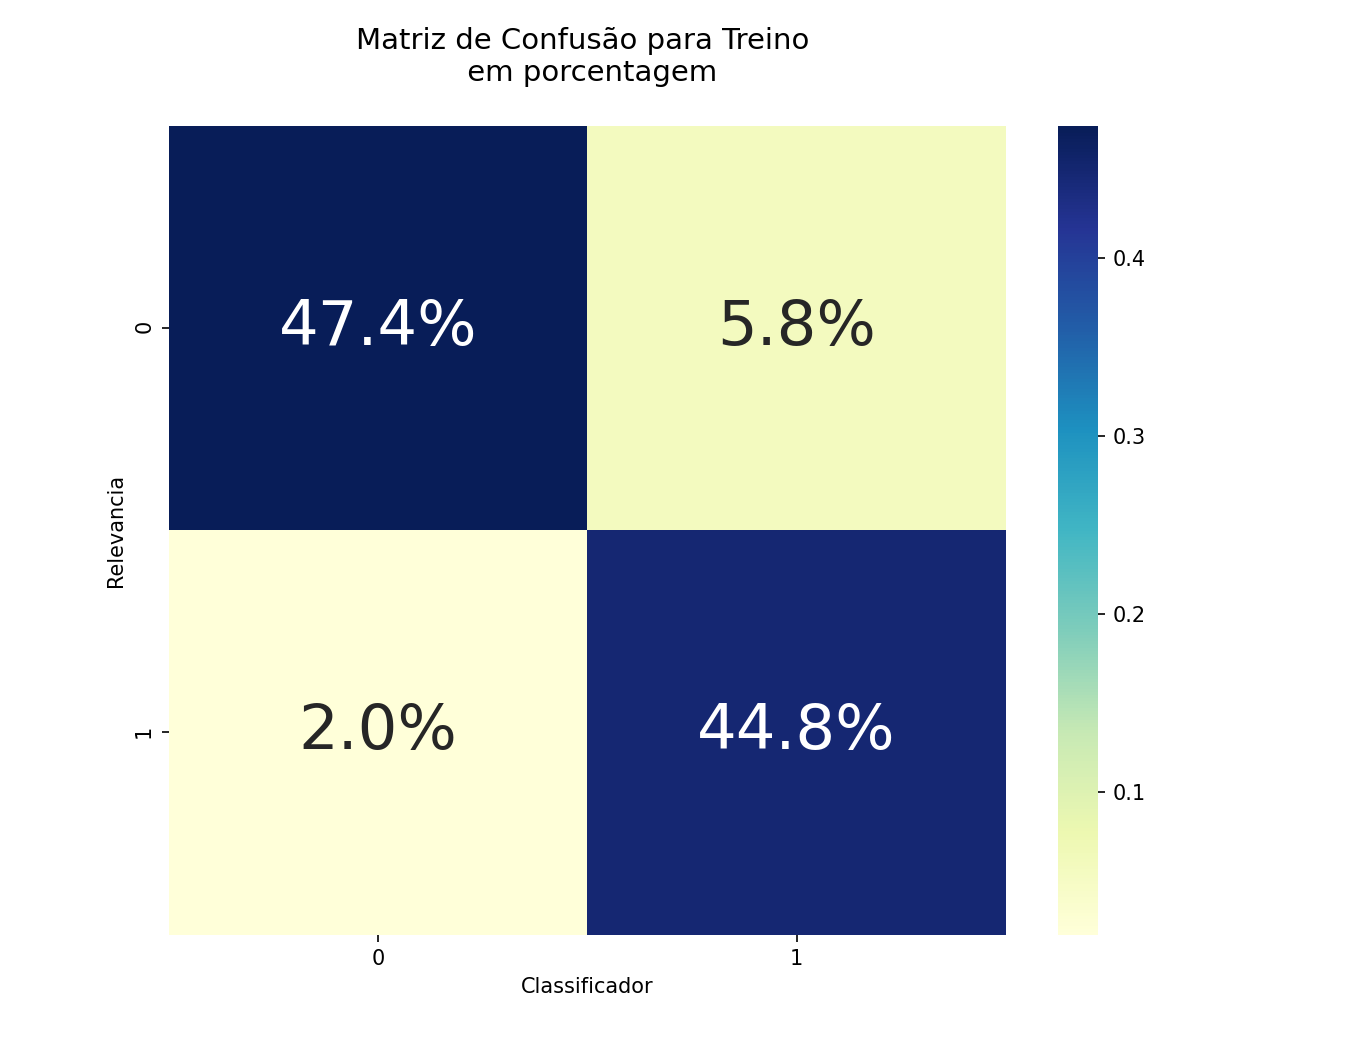

In [35]:
#Vendo a classificação efetiva
df_cm=pd.crosstab(train.Relevancia,train.Classificador,normalize=True)
plt.figure(figsize = (9,7))
plt.title('Matriz de Confusão para Treino \n em porcentagem\n',fontdict={'fontsize': 14})
sn.heatmap(df_cm, annot=True, annot_kws={"size":30},fmt='.1%',cmap='YlGnBu')

___
## Verificando a performance do Classificador

Iremos agora "apresentar" ao nosso modelo uma nova configuração de tweets, aos quais nçao estavam disponíveis na base de treinamento. Esperamos dessa forma que o modelo seja capaz de generalizar bem a essas situações reconhecendo palavras presentes na base de treinamento e se adaptando a novos contextos ou palavras estranhas.

In [36]:
#Aplicando no dataframe de teste
test['Classificador']=test.Clean.apply(Naive_Bayes)

In [37]:
tp=test.loc[(test['Classificador']==1)&(test['Relevancia']==1),:].shape[0]
tn=test.loc[(test['Classificador']==0)&(test['Relevancia']==0),:].shape[0]
print(f'A acurácia do modelo foi de: {100*(tp+tn)/test.shape[0]:.2f}%')

A acurácia do modelo foi de: 76.00%


<IPython.core.display.Javascript object>


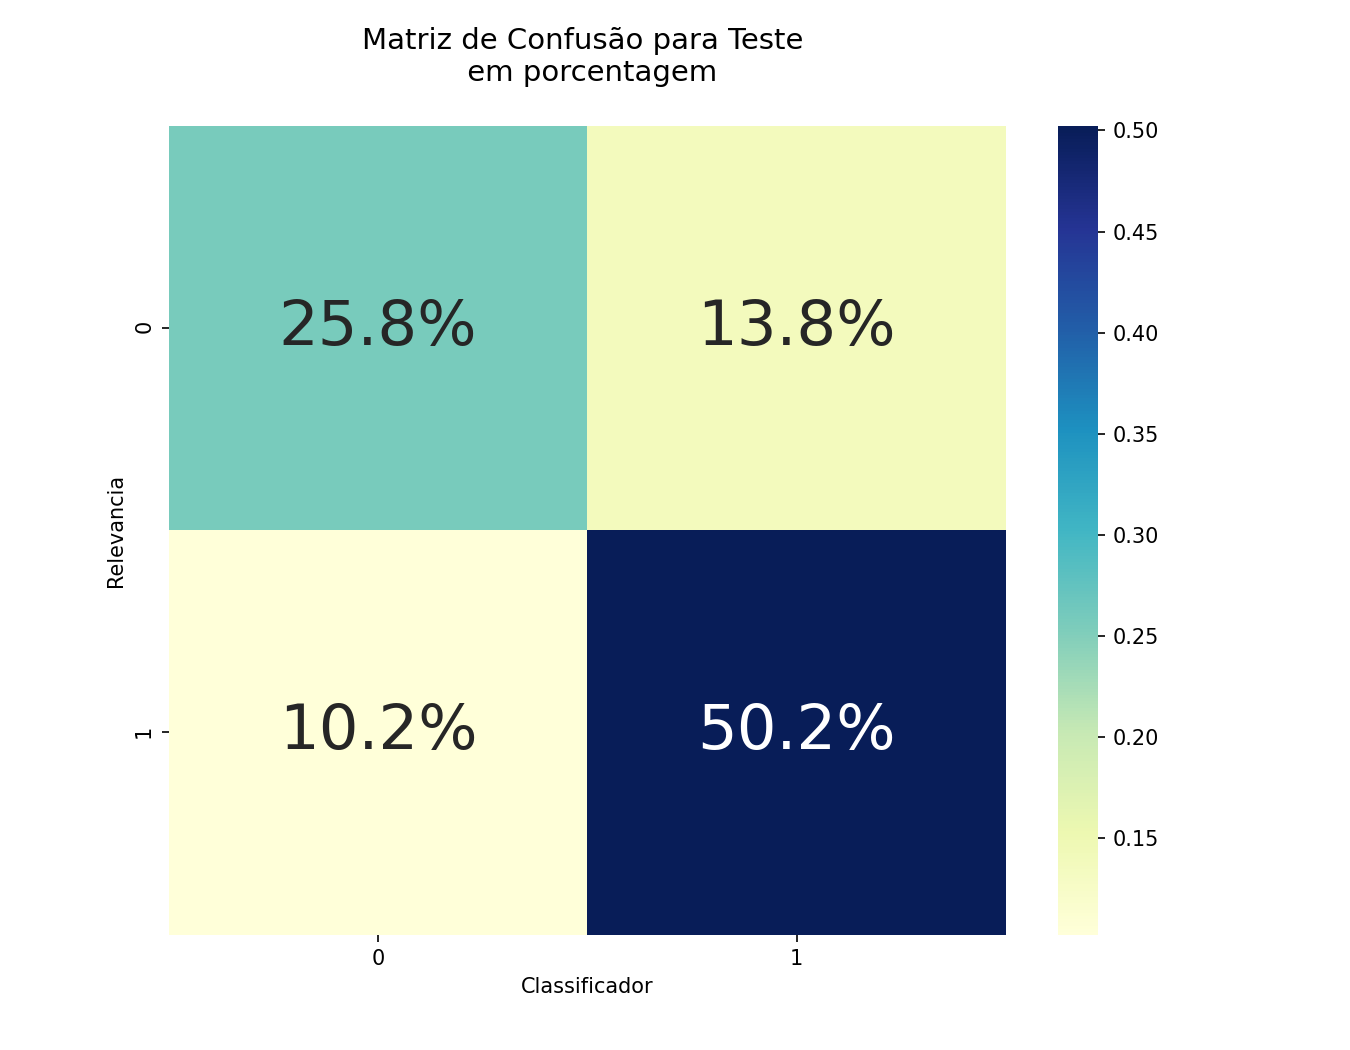

In [38]:
df_cm= pd.crosstab(test.Relevancia,test.Classificador,normalize=True)
plt.figure(figsize = (9,7))
plt.title('Matriz de Confusão para Teste \n em porcentagem\n',fontdict={'fontsize': 14})
sn.heatmap(df_cm, annot=True, annot_kws={"size": 30},fmt='.1%',cmap='YlGnBu')

___
## Concluindo

Como vimos nas matrizes de confusão, e nas próprias acurácias,o modelo teve uma perfomance razoável, acerta corretamente cerca de 75% das situações.

Todavia, grande parte dos erros obtidos no modelo advém da média porcentagem de Falsos Positivos, isto é, tweets que são irrelevantes e foram categorizados erroneamente como relevantes pelo modelo.

Isso retoma o fato de que como o Classificador é ingênuo, e desconsidera a dependência entre as palavras, muitos casos como de ambiguidade, dupla negação, sarcasmos ou ironias podem ser classificados erroneamente, visto que ele analisará matematicamente a probabilidade das palavras de constituição do tweet e não seu sentido. 

Outro fator que colabora para esse índice é o tamanho da base de dados que para fins de um classificador efetivo teria de ser maior, principalmente para uma maior variedade de palavras tal qual melhor assimilação de padrões que possam aumentar a probabilidade de determinadas palavras e termos, aumentando consideravelmente a capacidade de generalização do modelo para com novos tweets e situações.

Vale-se destacar que como esse classificador tem modelagem quase que estritamente matemática, sem muitas considerações semânticas e humanas, sua perfomance foi considerável dentro do possível, e com isso, agregando fatores e melhorias abaixo, sua perfomance tende a melhorar conseguindo cumprir com extrema eficácia sua proposição esperada.

##### Por que a perfomance entre Treino e Teste variou tanto? 

Outro fenômeno possivelmente que ocorreu no modelo é conhecido por <b> Overfitting.</b>

O modelo, apesar de conseguir criar um padrão de classificação ideal para a base de treinamento é incapaz de generalizar idealmente para novas amostras, exemplificando podemos dizer que o nosso modelo "acostuma-se" com certos padrões de repetição encontrados na base  de treinamento,tendendo a julgar de maneira repetitiva tweets que considera semelhante, diminuindo sua capacidade de abstração a novas situações. Isso ocorre, dentre outros motivos, devido ao tamanho da base de dados escolhida (relativamente pequena), a não <b>lematização das palavras</b> e pela não substiuição de sinônimos ou expressões adjuntas, que geram probabilidades diferentes para possíveis mesmo sentidos ou sentimentos expressos.

Esse fato explica por que tivemos uma diferença percentual de quase 15% entre a porcentagem de acertos para o Treinamento em relação aos Testes. 

Dessa forma,o Classificador foi satisfatório em sua análise. Melhorias realizadas poderiam ser:
- Cross-Fold
- Dicionário de sinônimos
- Lematização das palavras
- Base de dados de treinamento com maior quantidade de tweets


<img src="mandalorian_assets/overfitting.png" width=600 >
<center><b>Figura 1 - Situação descrita acima, na qual devido ao pequeno tamanho do dataset,<br> a disparidade entre os erros relativos é grande</b></center>

##### Por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador?

Como o modelo, nas condições aqui descritas, se restringe a meramente ferramentas matemáticas e probabíslisticas, ignorando assim quase que completamente fatores linguísticos, humanos e culturais dos enunciadores dos tweets, ele se torna incapaz de medir e abstrair de maneira correta sobre diferentes contextos de enunciação, prejudicando assim a capacidade de generalização deste caso ele fosse a fonte de alimentação da base de dados. 

Além disso, o modelo está sujeito ao viés da classificação manual realizada para os rótulos de comparação, durante a classificação manual que realizamos observamos o quão subjetivo pode ser essa analise, tendo sido necessário discussão para o consenso no rótulo de determinados tweets. Dessa forma, utilizar o modelo como ferramenta de alimentação acarretaria em uma enorme expansão desse viés, o que novamente prejudicaria sua generalização e tenderia a diminuir sua acurácia em novos contextos ou frases.

##### Sarcasmo e dupla negação

Como dito anteriormente o classifiador Naive Bayes é ingênuo por não levar em consideração a relação entre as palavras, considerando apenas a probabilidade das mesmas pertencerem ou não a determinada categoria. Portanto sacarmos e sentimentos do autor do tweet não são levados em consideração.

Em termos práticos, é basicamente observar como o classificador rotularia a situação abaixo, onde solicitaríamos a classificação de uma frase nitidamente sarcástica:

In [39]:
frase_sarcasmo = 'Mandalorian é tão legal quanto andar de ônibus lotado'

if Naive_Bayes(aplica(frase_sarcasmo))==1:
    print('A Frase é classificada como Relevante')
else:
    print('A Frase é classificada como Irrelevante')

A Frase é classificada como Relevante


In [40]:
dupla_neg = 'Mandalorian não é nada fantástico como dizem'
 
if Naive_Bayes(aplica(dupla_neg))==1:
    print('A Frase é classificada como Relevante')
else:
    print('A Frase é classificada como Irrelevante')

A Frase é classificada como Irrelevante


Como visto no exemplo, frases que possuem palavras que geram sentimento, de intensidade positiva ou negativa, ou apresentam palavras sarcásticas, ambíguas ou irônicas, serão provavelmnete classificadas de forma inadequada pelo Modelo.

##### Novos cenários para um classificador Naïve-Bayes

Como já citado inúmeras vezes nesse arquivo, o modelo é baseado quase que estritamente em ferramentas matemáticas, por tanto ele acaba por não ser extramemente funcional em contextos cuja a associação de palavras e sentido de frases sejam relevantes para sua classificação. Nesse certame, contextos mais simples, nos quais dependem apenas de palavras-chaves ou pequenas indicações, o classificador Naïve Bayes seria de grande eficácia. Um bom exemplo desse uso, poderia ser uma plataforma de streaming ou vídeos, dentre os quais, de acordo com as palavras mais digitadas pelo usuário em sua busca ou de acordo pelas palavras presentes em, por exemplo, títulos ou categorias desses vídeos, o modelo pudesse abstrair e recomendar com maior eficácia temas parecidos ou ligados a essas procuras, mantendo o usuário mais conectado na plataforma devido a maior sugestão de temas de seu interesse.

Outra aplicação em que o classificado Naive Bayes teria grande serventia seria quanto a diagnósticos médicos, julgando a probabilidade de um exame ter dado um Falso Positivo ou Negativo. O mesmo provavelmente apresentaria bom desempenho pelos mesmos motivos do exemplo anterior, diagnóstico de teste possuem palavras chaves e estão , em sua grande maioria, alheios a ambiguidades, assim poderiamos responder perguntas como: "se uma nova pessoa realizar o teste e receber um resultado positivo, qual a probabilidade dela realmente possuir a doença?", e sugerir a realização de um novo exame dependendo da resposta obtida.

___
## Aperfeiçoamento:


### Categorias Intermediárias

*Criando categorias intermediárias baseadas na probabilidade relativa estipulada pelo modelo*

Dentro das duas categorias que criamos (Relevante e Irrelevante) podemos encontras algumas subcategorias (Muito Irrelevante, Irrelevante, Neutro, Reletante e Muito Relevante).

Considere nesse exemplo que o tweet A e o tweet B foram classificados como relevante. Nessa nova classificação passariamos a considerar que caso a probabilidade de um tweet A ser relevante seja significadamente maior do que a probabilidade de um tweet B ser relevante, poderiamos dividir a "Relevância" em mais dois rótulos: tweet A passaria a pertencer a subcategoria "Muito Relevante" e o tweet B estaria na subcategoria "Relevante", ambos dentro da categoria Relevância. Racicioníneo análogo aplica-se aos subconjuntos "Muito Irrelevante" e "Irrelevante".


Caso tivessemos um tweet C que possui uma diferença de probabilidade ($P(R|tweetC)-P(I|tweetC)$) próxima de zero, poderiamos subclassifica-lo como um tweet "Neutro".

Definindo novas funções utilizadas para categorias intermediárias:

In [41]:
def Naive_Bayes_new_categories(tweet):
    """
    Retorna a diferença entre as probabilidades que serão usadas mais 
    tarde para a reclassificação de acordo com o grau estabelecido
    """
    return P_tweet_r(tweet)*P_r -P_tweet_i(tweet)*P_i

def Separando_em_categorias(prob):
    
    '''
    Função recebe um valor de probabilidade. 
    Retorna rótulo Muito Irrelevante, Irrelevante, Neutro, Relevante ou Muito Relevante
    '''
    
    #Criando uma lista ordenada com os valores de probabilidade em ordem.
    prob_lista=test_categorie_degree.Prob.sort_values().tolist()
    
    #Contador que busca ponto de virada do sinal na lista ordenada de probabilidade.
    troca_sinal=0
    
    #Posição ultimo elemento da lista:
    pos_ultimo=len(prob_lista)
    
    for i, value in enumerate(prob_lista):
            
            if(value<0):           
                continue
            else:
                #Posição em que os valores mudam para positivo na lista ordenada de probabilidade
                troca_sinal=i                 
                break
    
    #Probabilidade recebida interpretada como neutra para valores próximos de 0
    if prob in prob_lista[troca_sinal-5:troca_sinal+10]:
         return 'Neutro'                       
    
    #Na classificação Relevante,Irrelevante buscamos metade das parcelas restantes do intervalo anterior e posterior 
    #ao neutro para a subdivisão: (Relevante, Muito relevante) e (Irrelevante, Muito irrelevante)
    
    else:    
        
        # Para a condição em que a probabilidade é negativa podemos dividi-la em 2 Subgrupos
        if prob < 0:
            
            #Primeira parcela de valores negativos (Valores mais negativos)
            if prob in prob_lista[0:ceil((troca_sinal-5)/2)]:
                return 'Muito Irrelevante'
            
            #Segunda parcela de valores negativos (Valores menos negativos)
            return 'Irrelevante'
        
        # Para a condição em que a probabilidade é positiva podemos dividi-la em 2 Subgrupos
        else:
            
            #Primeira parcela de valores positivos (Valores menos positivos)
            if prob in prob_lista[(troca_sinal+10):ceil((troca_sinal+10)+(pos_ultimo-(troca_sinal+10))/2)]:
                return 'Relevante'
            
            #Segunda parcela de valores positivos (Valores mais positivos)
            return 'Muito Relevante'

In [42]:
# Copiando conjunto teste e aplicando nova classificação:
test_categorie_degree=test.copy()
test_categorie_degree['Prob']=test_categorie_degree['Clean'].apply(Naive_Bayes_new_categories)

In [43]:
test_categorie_degree['Grau de Relevancia']= test_categorie_degree.Prob.apply(Separando_em_categorias)
test_categorie_degree=test_categorie_degree.drop('Prob',axis=1)
test_categorie_degree

,Teste,Relevancia,Clean,Classificador,Grau de Relevancia
0,the mandalorian é uma série com dinheiro e tec...,1,"the,mandalorian,série,dinheiro,tecnicamente,bo...",1,Relevante
1,agora comecei mandalorian confiando novamente ...,1,"agora,comecei,mandalorian,confiando,novamente,...",0,Irrelevante
2,@fepazo1 @gabriel_ns1999 @joelmsimmons @jurand...,1,"fepazo1,gabriel_ns1999,joelmsimmons,jurandirfi...",0,Neutro
3,eu assisti 3 minutos de mandalorian e emocionei,1,"assisti,3,minutos,mandalorian,emocionei",1,Muito Relevante
4,rt @anakinwar: já ta ...,0,"anakinwar,ta,mãe,chorando,final,dnv,garota,the...",1,Relevante
...,...,...,...,...,...
220,"tô com saudade de the mandalorian, acho que vo...",1,"tô,saudade,the,mandalorian,acho,vou,ver,tudo,novo",1,Muito Relevante
221,meu deus pedro pascal é o mandalorian 😱😱😱😱😱😱😱,1,"deus,pedro,pascal,mandalorian,rosto_gritando_d...",1,Relevante
222,@39marukin @ghostjacobs tem. assisti lá.\nagor...,1,"39marukin,ghostjacobs,assisti,lá,agora,finalme...",1,Relevante
223,@ip_mandalorian @tmarretamma ficou parecendo o...,0,"ip_mandalorian,tmarretamma,ficou,parecendo,peq...",0,Irrelevante


In [44]:
test_categorie_degree['Grau de Relevancia'].value_counts()

Muito Relevante      67
Relevante            67
Irrelevante          38
Muito Irrelevante    38
Neutro               15
Name: Grau de Relevancia, dtype: int64

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Iremos agora fazer diferentes separações da base de dados em treino e teste de maneira aleatória e variada.

- Primeiramente iremos hospedar novamente a base de dados;
- Concatenar ambos os Dataframe de Teste e Treinamento em um só;
- Aplicar a função de limpeza no Dataframe resultante.

In [45]:
#Juntando os tweets em um unico DF
test_split = pd.read_excel(filename, sheet_name = 'Teste')
test_split = test_split.rename(columns={'Teste':'Total'})
test_split.head()

train_split = pd.read_excel(filename, sheet_name = 'Treinamento')
train_split = train_split.rename(columns={'Treinamento':'Total'})

#Concatenando as tabelas
data_set=pd.concat([train_split,test_split])

#Limpando os tweets
data_set['Clean']=data_set['Total'].apply(aplica)
data_set.head()

#garatindo que a concatenação manteve toda a base de tweets
assert test.shape[0]+train.shape[0]==data_set.shape[0]

##### Ajustando funções e parâmetros
- Iremos agora ajustar as funções de cálculo de probabilidade e classificação para que elas se adequem ao loop de repetição, principalmente ajustando as variáveis globais;
- Para tal, ajustaremos alguns parâmetros como a quantidade de palavras possíveis (vinda do treinamento que será splittado aleatoriamente a cada loop) e as listas de relevantes e irrelevantes de cada loop, para que mudem de acordo com a repetição, alterando os elementos de seu conjunto.

In [81]:
palavras_r_split=palavras_r
palavras_i_split=palavras_i

def count_palavras_novas(tweet):
    '''
    Conta o número de palavras novas por tweet
    '''
    
    count_nova=0    # Quantas vezes palavras novsa aparecem no tweet
    
    total_palavras=pd.concat([palavras_r_split,palavras_i_split])  #Concatena serie de palavras relevantes e irrelevantes.
    total_palavras=total_palavras.value_counts()                #Quantidade de cada palavras no conjunto total de palavras.
    
    quebra_tweet=tweet.split(',')

    for palavra in quebra_tweet:
        fa=freq_absoluta(palavra,total_palavras)                
        if fa==0:                                       #Quando a palavra não é identificada na lista de palavras totais. 
            count_nova+=1                               #Somar palavras novas no contador.
        else:
            continue
    return count_nova

##### Utilizaremos aqui o módulo sklearn que é próprio para análises de Machine Learning

Nele iremos importar a função 

>**train_test_split**

Essa função basicamente divide o conjunto de dados de Treinamento e teste em 4 variáveis, conhecidas como, respectivamente,
atributos de Treinamento, atributos de Teste, rótulos de Treino e rótulos de Teste, e em seus parâmetros internos podemos dividir a quantidade relativa de teste/treino que desejamos.
Adotaremos a preposição de 30% da base de dados para treino, emulando de maneira próxima a proporção utilizada no dataset original.
 Nota-se também que como não alteraremos o parâmetros <em>random_state</em> a função sempre irá dividir a base de dados diferentemente em cada repetição, atingindo o princípio esperado de Validação Cruzada deste item.

In [73]:
from sklearn.model_selection import train_test_split

lista_hist=[]
lista_proporcao_r=[]
numero_palavras_novas=[]

for i in range(0,100):
    
    X_train,X_test,y_train,y_test=train_test_split(data_set[['Clean','Relevancia']],data_set.Relevancia,
    test_size=0.3)

    train_relevantes_new=X_train[X_train['Relevancia']==1]
    train_irrelevantes_new=X_train[X_train['Relevancia']==0]

    palavras_r_split= frases_to_words(train_relevantes_new['Clean'])
    palavras_i_split= frases_to_words(train_irrelevantes_new['Clean'])
    
    rel_relevantes=palavras_r_split.value_counts()
    rel_irrelevantes=palavras_i_split.value_counts()
    
    prop=palavras_r_split.shape[0]/(palavras_r_split.shape[0]+palavras_i_split.shape[0])
    
    list_i=palavras_i_split.tolist()
    list_r=palavras_r_split.tolist()

    total=pd.Series(list_i+list_r)

    P_r=len(list_r)/len(total)
    P_i=len(list_i)/len(total)
    assert P_r+P_i==1

    elementos_nao_repetidos=set(list_i+list_r)

    X_test['Classificador']=X_test.Clean.apply(Naive_Bayes)
    X_test['Palavras Novas']=X_test.Clean.apply(count_palavras_novas)

    verdadeiro_positivo=X_test.loc[(X_test['Classificador']==1)&(X_test['Relevancia']==1),:].shape[0]
    verdadeiro_negativo=X_test.loc[(X_test['Classificador']==0)&(X_test['Relevancia']==0),:].shape[0]
    score=(verdadeiro_positivo+verdadeiro_negativo)/X_test.shape[0]
    
    lista_hist.append(score*100)
    lista_proporcao_r.append(prop*100)
    numero_palavras_novas.append(sum(X_test['Palavras Novas'].tolist()))

#### Scores para o Modelo com cross-validation

<IPython.core.display.Javascript object>


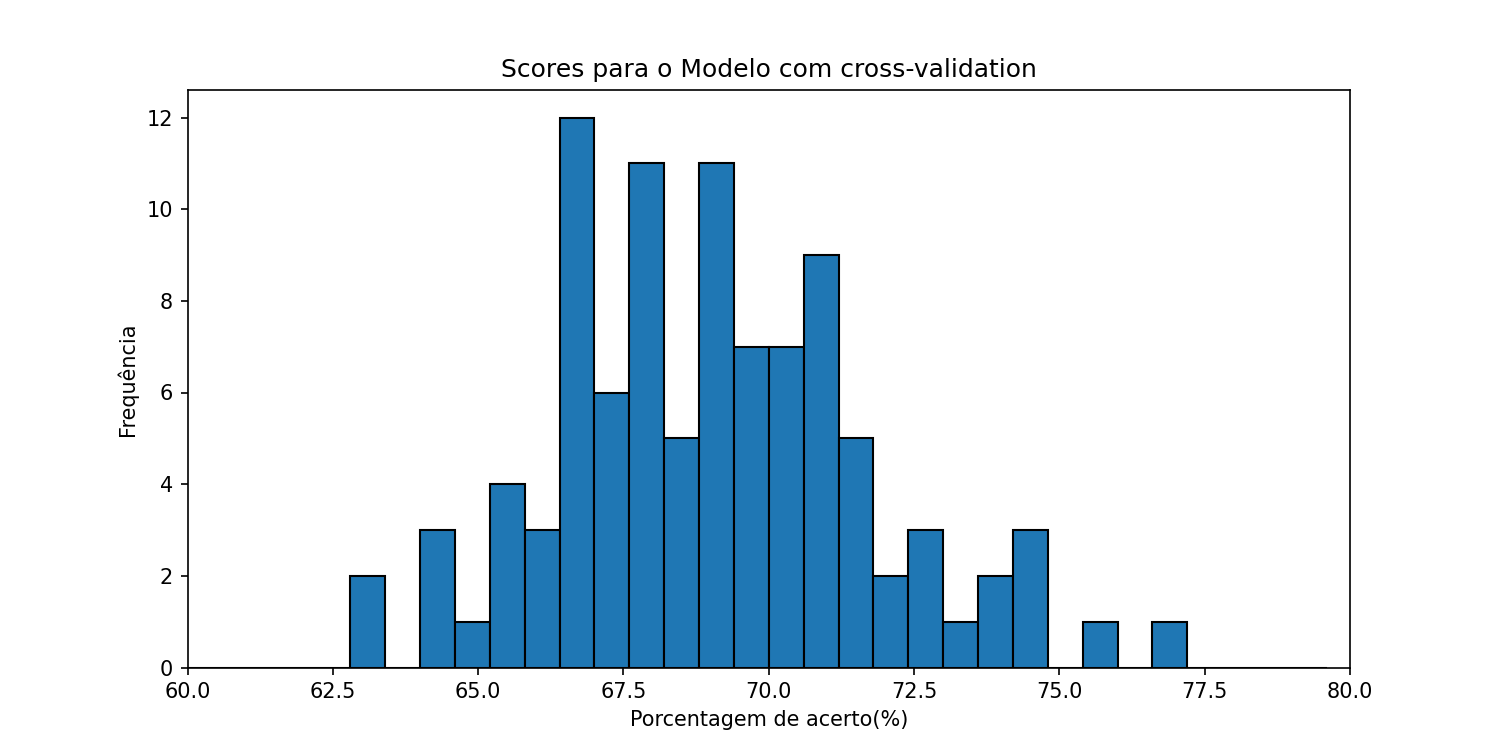

In [74]:
faixa=np.arange(55,80,0.6)
plt.figure(figsize=(10, 5))
plt.hist(lista_hist, bins=faixa, edgecolor='black', density=False)
plt.title('Scores para o Modelo com cross-validation')
plt.ylabel('Frequência')
plt.xlabel('Porcentagem de acerto(%)')
plt.xlim(60,80)
plt.show()

In [75]:
mean=sum(lista_hist)/len(lista_hist)
mean
max(lista_hist)
print(f'Score máximo:\t{max(lista_hist):.2f}\nScore mínimo:\t{min(lista_hist):.2f}\nScore médio:\t{mean:.2f}')

Score máximo:	77.06
Score mínimo:	59.63
Score médio:	68.94


**Vendo o histograma acima, averigua-se uma grande variabilidade de porcentagem de acertos para configurações diversas de conjunto Treinamento/Teste. Caso realizassemos essa configuração somente uma vez, tal qual foi feita para esse projeto, teriamos uma grande chance de obtermos altos percentuais de acertos assim como de obtermos percentuais mais baixos, conforme ilustrado graficamente. 
Dessa forma ressalta-se as desvantagens em se dividir a base de dados uma única vez, visto que nem sempre essa partição retornará o melhor desempenho na classifição dos tweets. 
Assim, conclue-se que sempre que possível, realizar o processo de Validação Cruzada, é um fator de grande estímulo para o melhor desempenho do modelo, dado que é possível ver a melhor configuração e adequa-la a situação requerida.** 

*OBS: Para salvar a melhor configuração do modelo que obteve a melhor porcentagem de acerto pode-se usar o módulo:*
> <a href=https://docs.python.org/3/library/pickle.html>Pickle</a> 

Ele salva a conjuntura do modelo em um arquivo JSON, que pode depois ser guardado fora do loop de repetição, para assim certificar o melhor desempenho do modelo.

#### Proporção palavras relevantes e sua relação com os scores obtidos

Dada as novas separações entre treinamento e teste, a proporção de tweets relevantes e irrelevantes pelo total, muda. Dessa forma analisamos qual a correlação dessa mudança com os scores (verdadeiros positivos/verdadeiros negativos). 

<IPython.core.display.Javascript object>


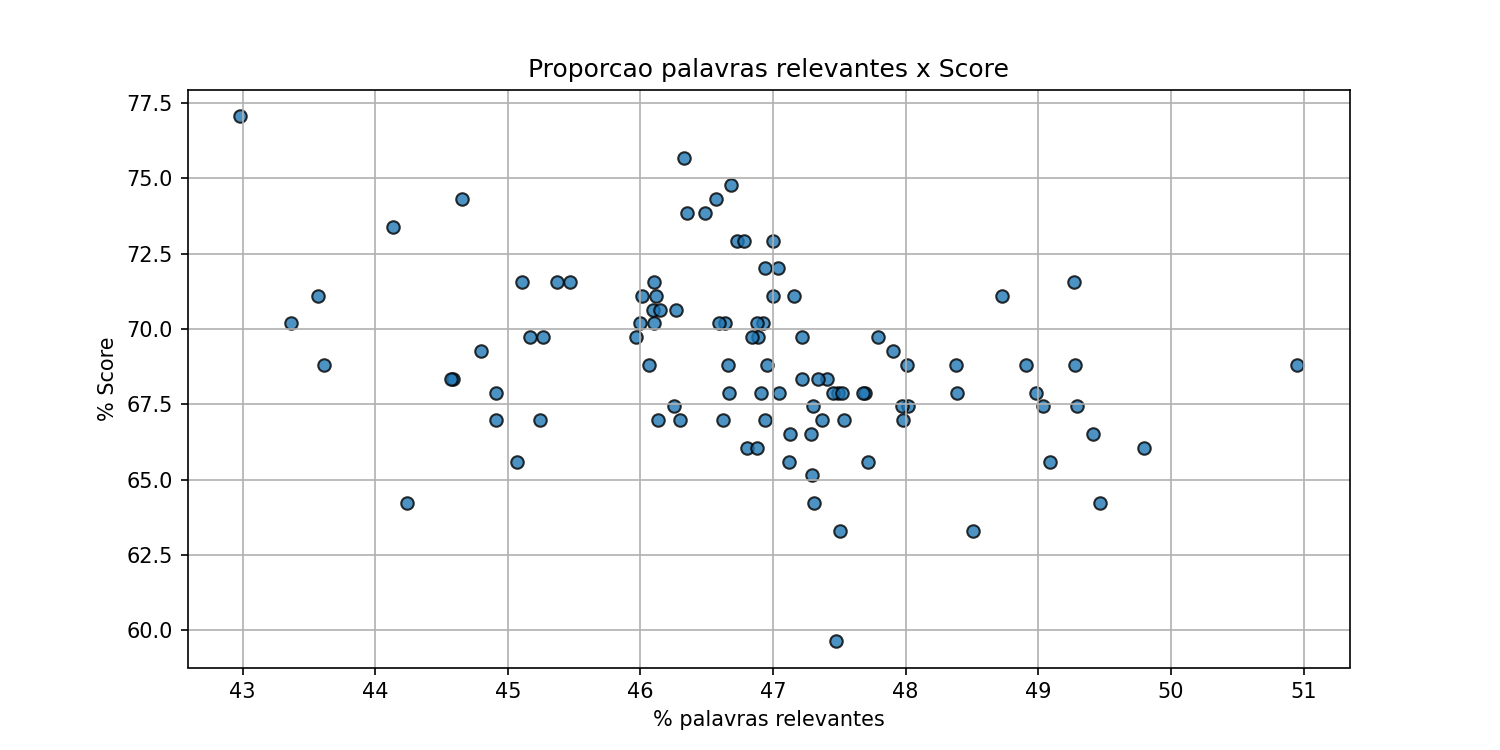

In [76]:
plt.figure(figsize=(10, 5))

plt.scatter(lista_proporcao_r,lista_hist, edgecolor='black', alpha=0.8)
plt.title('Proporcao palavras relevantes x Score')
plt.xlabel('% palavras relevantes')
plt.ylabel('% Score')
plt.grid(True)
plt.show()

In [77]:
lista_proporcao_r=pd.Series(lista_proporcao_r)
lista_hist=pd.Series(lista_hist)

lista_hist.corr(lista_proporcao_r).round(decimals=4)

-0.3475

Como vimos pelo gráfico e pelo valor resultante da correlação, temos uma associação do tipo fraca/moderada negativa. Observamos também que a proporções de palavras relevantes encontra-se entre 44% e 49% majoritariamente, valores próximos ao data set original que foi utilizado para o treinamento do modelo.

#### Quantidade de palavras novas e sua relação com os scores obtidos

Dada as novas separações entre treinamento e teste, a quantidade de palavras novas obtidas em cada dataset varia. Dessa forma analisamos qual a correlação entre o número de palavras novas com os scores (verdadeiros positivos/verdadeiros negativos).

<IPython.core.display.Javascript object>


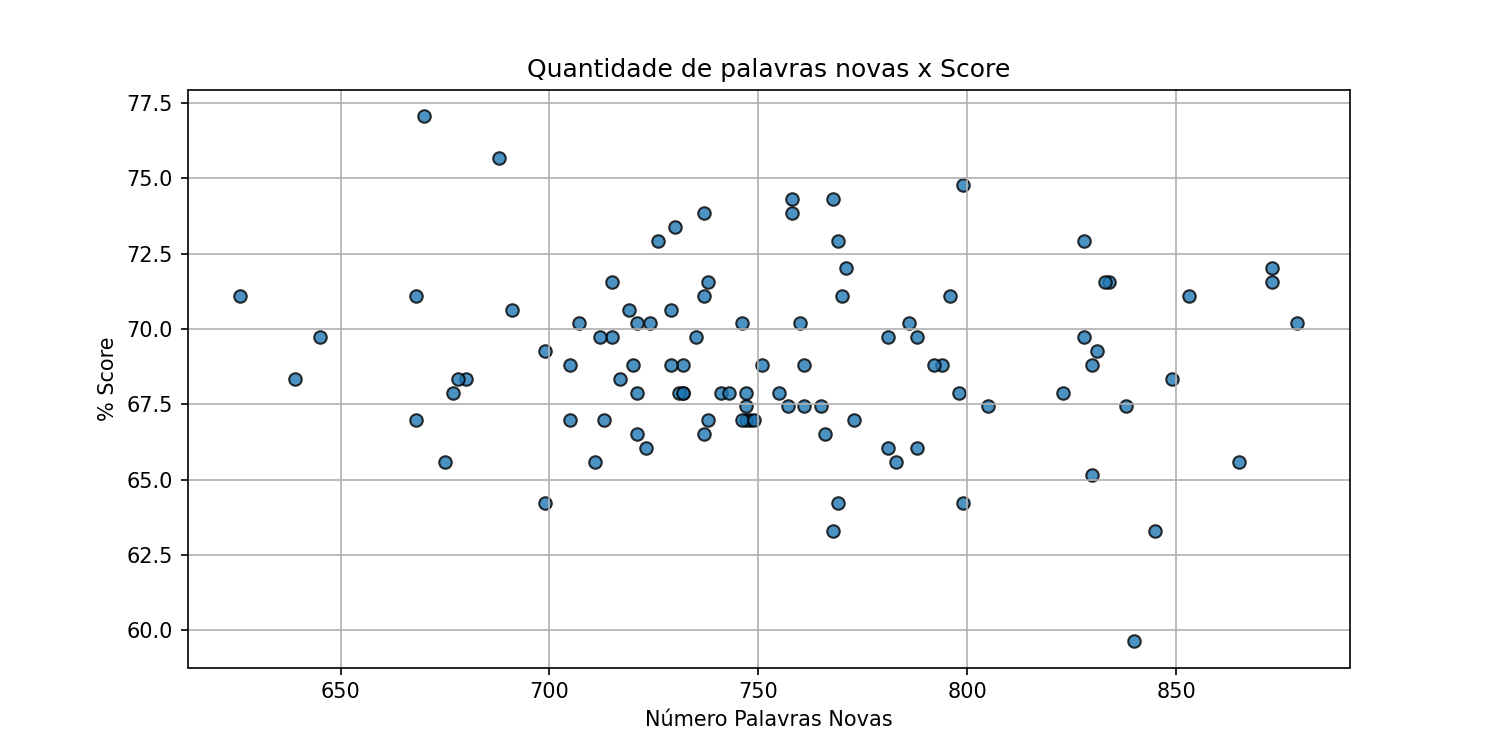

In [78]:
plt.figure(figsize=(10, 5))

plt.scatter(numero_palavras_novas,lista_hist, edgecolor='black', alpha=0.8)
plt.title('Quantidade de palavras novas x Score')
plt.xlabel('Número Palavras Novas')
plt.ylabel('% Score')
plt.grid(True)
plt.show()

In [79]:
numero_palavras_novas=pd.Series(numero_palavras_novas)

lista_hist.corr(numero_palavras_novas)

-0.09254498223014396

Analisando o gráfico e o valor obtido da correlação, vemos que não há relação entre as duas variáveis, sendo sua associação classificada como fraca negativa.

### Melhorias para o Modelo

#### Criando uma agregação probabilística de Sinônimos

Muitas palavras dentro da base de dados representam o mesmo conjunto de sentimentos ou tem grau de intensidade parecido, todavia terão diferentes probabilidades pelo Classificador devido a falta da consideração de Sinonímia entre estas. 

Criando uma função dicionário, muito parecida com a abaixo, que usa a biblioteca Psynonimos, seria possível, analisar se determinada palavra pertence a um conjunto de palavras sinônimas e associar a probabilidade desse conjunto pertecenter de maneira igual ao dataset. Dessa forma, o grau de classificação ficaria com maior possibilidade de acerto, visto que reduziria a classificação independente siginificativamente de palavras pouco usadas, mas com mesmo sentido de algumas mais comuns.

Para mais informações sobre esse módulo conferir em: https://github.com/diegofsousa/pysinonimos

Basicamente após a captação das palavras via base de dados de treinamento após 
os processos de transcrição realizados [nesta etapa](#captacao), iriamos reduzir o conglomerado de palavras para um conglomerado de sinônimos, agregados ou em uma string ou em uma lista, garantindo assim que palavras com mesmo sentido tenham mesma probabilidade estatística, reduzindo erros advindos da comunalidade ou não de palavras análogas.

In [55]:
#Suponha que nosso armazenamento de palavras relevantes obtidas da base de treinamento seja o seguinte:
palavras_r=pd.Series(['assistir','mandalorian','gosto','muito','deixa',
                      'muita','alegria','star','wars','alegria','assistir'])

#Assim, o tweet a ser analisado seja o seguinte:
tweet="Ver mandalorian me traz felicidade"

#Como podemos averiguar, as palavras "Ver" e "felicidade" tem os sinônimos "assistir" e "alegria"
#na base de dados. Toda via, como são diferentes, apesar de seu sentido, sua probabilidade será suavizada
#por Laplace, visto que é uma palavra nova, e dessa forma, iremos agregar uma probabilidade diferente 
#a "felicidade" e "alegria" mesmo estas tendo mesmo sentido e intensidade em grande parte dos contextos

#Para contornar esse problema, podemos usar o modulo Psynonimos, que gera uma lista de sinônimos
#para algumas palavras, e analisando essa lista, podemos associar algumas palavras a outras existentes
#aumentando assim a eficácia do classificador, que agora não mais irá atribuir diferentes probabilidades
#para palavras sinônimas, mas com grau de comunalidade diferente

#Limpando o tweet
tweet_limpo=aplica(tweet)

#Modificando a função de contagem da palavra para associar sinonimos
def freq_absoluta_sin(palavra,lista):
    """
    Conta quantas vezes determinada palavra apareceu 
    na respectiva categoria, seja relevante ou irrelevante
    """
    nova=sinom.Search(palavra).synonyms()   #Lista com sinônimos da palavra, se estes existirem
    count=0
    for i in range(0,len(lista)):
        if palavra==lista[i]:
            count+=1   
        else:
            if nova!=404:                 #Condição de existência da lista de sinônimo
                if lista[i] in nova:      #Se a palavra da da base de treino tem algum sinônimo a palavra analisada
                    count+=1              #Esse também é considerado como parte da probabilidade  
                else:
                    continue
            else:                       #Não existe lista de sinônimos
                continue                 #Caso da palavra que não possui sequer sinônimos na base de treinamento
    return count

for palavra in tweet_limpo.split(','):
    print(f'O número de vezes que contamos a "{palavra}" ou algum sinônimo\
    na base de dados foi {freq_absoluta_sin(palavra,palavras_r)}')

O número de vezes que contamos a "ver" ou algum sinônimo    na base de dados foi 2
O número de vezes que contamos a "mandalorian" ou algum sinônimo    na base de dados foi 1
O número de vezes que contamos a "traz" ou algum sinônimo    na base de dados foi 0
O número de vezes que contamos a "felicidade" ou algum sinônimo    na base de dados foi 3


*Como podemos ver acima, mesmo que as palavras "ver" e "felicidade" não existirem na base de treino, seus sinônimos, respectivamente ("assistir") e ("gosto" e "alegria"), pertencem a base e por possuírem sentidos iguais, estas palavras contribuem para a frequência absoluta na classificação gerando, dessa forma, uma classificação mais efetiva da frase.*

#### Adotando uma lematização entre as palavras

Para a língua Inglesa, por exemplo, já existem módulos prontos, dentro da própria biblioteca <b>ntlk</b> que conseguem seperar blocos de palavras e conseguir assim extrair sentimento e intensidade desses, gerando assim uma dependência entre as palavras, intensificando a probabilidade correta de um tweet.

Dessa forma, o nosso objetivo seria a implantação de uma função ou programa que de maneira automatizada conseguisse aprender sobre o grau de associação entre as palavras de acordo com seu rótulo. Para isso seriam necessários uma maior base de dados além de uma classificação mais refinada, com critérios e categorias mais elaboradas que possam assim melhorar a qualidade e interpretação do modelo pela lematização e grau de associação entre palavras próximas.

Mais sobre esse processo e algoritmos em desevolvimento para essa captação associativa entre as palavras pode ser visto em:
https://lars76.github.io/2018/05/08/portuguese-lemmatizers.html#4

#### Aumentando o tamanho e atualização da base de dados com Web Scrapping

Apesar de já possuírmos uma quantidade razóavel para constituir o modelo, para mantê-lo sempre o máximo eficaz e atualizado, seria necessário uma busca e atualização constante de tweets diretamente da plataforma. 

Com esse fator, poderíamos simultaneamente treinar o Classificador com novas situações em relação ao produto, como por exemplo a introdução de um novo personagem ou a impressão do público sobre uma nova temporada, tal qual evitar erros de Overfitting e Underfitting gerados pela constância de tamanho da base de dados.

Para realizar esse fato, seria necessário solicitar uma nova licensa, mais ampla, ao Twitter para que o processo de tweets seja mais constante em menores períodos de tempo, tal qual mais eficaz de acordo com a busca, uma busca por termos mais efetivos.

Uma boa maneira de optimizar esse processo é além do uso do módulo Tweepy, fazer uso da biblioteca Beatifulsoap. Para mais informações, veja o artigo Indiano que explica um pouco mais: https://towardsdatascience.com/web-scraping-for-beginners-beautifulsoup-scrapy-selenium-twitter-api-f5a6d0589ea6

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**